# 자동차 가격 예측하기(Car Price Estimate probabiliy)<br>회귀분석(Regression)
###### Written by Do-kon Kim

## 1. 데이터 적재(Data Load)

In [1]:
#!pip install hdfs
##!pip uninstall hana_ml -y
#!pip install hana_ml --upgrade

#### HANA ML Python API 최신 버전으로 Update

In [2]:
!pip install hana_ml --upgrade

Requirement already up-to-date: hana_ml in /opt/conda/lib/python3.7/site-packages (2.8.21042100)


In [3]:
import hana_ml
print(hana_ml.__version__)

2.8.21042100


#### Data Lake에 저장된 autos.csv 데이터세트를 DataFrame으로 읽어들이기 

In [4]:
from hdfs import InsecureClient
client = InsecureClient('http://datalake:50070')

In [5]:
import pandas as pd
with client.read('/shared/Demo/autos.csv', encoding='Windows-1252') as reader:
    df_data = pd.read_csv(reader, sep=',')
df_data.head(5)

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
#import pandas as pd
#df_data = pd.read_csv('autos.csv', encoding = 'Windows-1252')
#df_data.head(5)

In [7]:
#### 컬럼명을 대문자로 변경하기

In [8]:
df_data.columns = map(str.upper, df_data.columns)

#### 전체 데이터세트에서 필터(조건)으로 데이터세트 선택하기

In [9]:
df_data = df_data[df_data['BRAND'] == 'mercedes_benz']    # Keep only Mercedes Benz
df_data = df_data[df_data['OFFERTYPE'] == 'Angebot']      # Keep only cars for sale (excluding adverts for purchasing a car)
df_data = df_data[df_data['SELLER'] == 'privat']          # Keep only sales by private people (excluding commercial offers)
df_data = df_data[df_data['NOTREPAIREDDAMAGE'] == 'nein'] # Keep only cars that have no unrepaired damage

#### 불필요한 컬럼(속성) 삭제하기

In [10]:
df_data = df_data.drop(['NOTREPAIREDDAMAGE',
                        'NAME', 
                        'DATECRAWLED', 
                        'SELLER', 
                        'OFFERTYPE', 
                        'ABTEST', 
                        'BRAND', 
                        'DATECREATED',
                        'NROFPICTURES', 
                        'POSTALCODE', 
                        'LASTSEEN', 
                        'MONTHOFREGISTRATION'],
                         axis = 1)

#### 컬럼명 변경하기

In [11]:
df_data = df_data.rename(index = str, columns = {'YEAROFREGISTRATION': 'YEAR',
                                                 'POWERPS': 'HP'})

#### 특정 데이터 값 치환하기

In [12]:
df_data['MODEL'] = df_data['MODEL'].replace({'a_klasse': 'A-Class',
                                             'b_klasse': 'B-Class',
                                             'c_klasse': 'C-Class',
                                             'e_klasse': 'E-Class',
                                             'g_klasse': 'G-Class',
                                             'm_klasse': 'M-Class',
                                             's_klasse': 'S-Class',                                     
                                             'v_klasse': 'V-Class',                                       
                                             'cl': 'CL',  
                                             'sl': 'SL', 
                                             'gl': 'GL', 
                                             'clk': 'CLK',   
                                             'slk': 'SLK',
                                             'glk': 'GLK',  
                                             'sprinter': 'Sprinter',  
                                             'viano': 'Viano',  
                                             'vito': 'Vito',                                        
                                             'andere': 'Other'                                        
                                             })
df_data['GEARBOX']  = df_data['GEARBOX'].replace({'manuell': 'manual',
                                                  'automatik': 'automatic'})
df_data['FUELTYPE'] = df_data['FUELTYPE'].replace({'benzin': 'petrol'})

#### 컬럼 CAR_ID 추가하기

In [13]:
df_data.insert(0, 'CAR_ID', df_data.reset_index().index)

In [14]:
df_data = df_data[pd.Index.append(df_data.columns.drop("PRICE"), pd.Index(['PRICE']))]

#### 최종 데이터세트

In [15]:
df_data

,CAR_ID,VEHICLETYPE,YEAR,GEARBOX,HP,MODEL,KILOMETER,FUELTYPE,PRICE
19,0,bus,2004,manual,102,A-Class,150000,petrol,1850
30,1,limousine,1995,automatic,113,E-Class,150000,diesel,3300
34,2,limousine,2004,automatic,122,E-Class,150000,diesel,3500
39,3,bus,1984,manual,70,Other,150000,diesel,1500
49,4,bus,2012,automatic,109,B-Class,150000,diesel,13500
...,...,...,...,...,...,...,...,...,...
371465,26895,bus,2002,manual,66,Vito,150000,diesel,1650
371478,26896,kleinwagen,2001,manual,95,A-Class,150000,diesel,1300
371483,26897,limousine,2012,automatic,136,E-Class,60000,diesel,20500
371489,26898,bus,2007,manual,0,B-Class,125000,petrol,7900


#### HANA DB 세션 연결

In [16]:
from notebook_hana_connector.notebook_hana_connector import NotebookConnectionContext
conn = NotebookConnectionContext(connectionId = 'XA2648_HANA')

#### 최종 데이터세트의 HANA Table 생성하기

In [17]:
import hana_ml.dataframe as dataframe
df_remote = dataframe.create_dataframe_from_pandas(connection_context = conn, 
                                                   pandas_df = df_data, 
                                                   table_name = 'USEDCARPRICES_TA99',
                                                   schema = 'XA2664_01',
                                                   force = True,
                                                   replace = False)

100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


#### 신규(예측 대상) 데이터세트 생성하기

In [18]:
df_topredict = pd.DataFrame(data = None, 
                            columns = df_data.columns.drop('PRICE'))
for xx in df_topredict.columns:
    df_topredict[xx] = df_topredict[xx].astype(df_data[xx].dtypes.name)

In [19]:
df_topredict = df_topredict.append({'CAR_ID': 1, 
                                    'VEHICLETYPE': 'coupe', 
                                    'YEAR': 2006, 
                                    'GEARBOX': 'manual', 
                                    'HP': 232,  
                                    'MODEL': 'CLK', 
                                    'KILOMETER': 50000,
                                    'FUELTYPE': 'petrol'}, 
                                    ignore_index = True)
df_topredict = df_topredict.append({'CAR_ID': 2, 
                                    'VEHICLETYPE': 'coupe', 
                                    'YEAR': 2006, 
                                    'GEARBOX': 'manual', 
                                    'HP': 232,  
                                    'MODEL': 'CLK', 
                                    'KILOMETER': 150000,
                                    'FUELTYPE': 'petrol'}, 
                                    ignore_index = True)

#### 신규(예측 대상) 데이터세트의 HANA Table 생성하기

In [20]:
df_remote = dataframe.create_dataframe_from_pandas(connection_context = conn, 
                                                   pandas_df = df_topredict, 
                                                   table_name = 'USEDCARPRICES_TOPREDICT_TA99',
                                                   schema = 'XA2664_01',
                                                   force = True,
                                                   replace = False)

100%|██████████| 1/1 [00:00<00:00, 81.12it/s]


#### HANA DB 세션 종료

In [21]:
conn.close()

#### 

## 2. 탐색적 데이터 분석(Data Exploration)

#### HANA DB 세션 연결

In [22]:
from notebook_hana_connector.notebook_hana_connector import NotebookConnectionContext
conn = NotebookConnectionContext(connectionId = 'XA2648_HANA')

#### Table 데이터세트를 HANA DataFrame으로 읽어들이기

In [23]:
import hana_ml.dataframe as dataframe
df_remote = conn.table(table = 'USEDCARPRICES_TA99', schema = 'XA2664_01')

In [24]:
df_remote.head(n = 5).collect()

,CAR_ID,VEHICLETYPE,YEAR,GEARBOX,HP,MODEL,KILOMETER,FUELTYPE,PRICE
0,0,bus,2004,manual,102,A-Class,150000,petrol,1850
1,1,limousine,1995,automatic,113,E-Class,150000,diesel,3300
2,2,limousine,2004,automatic,122,E-Class,150000,diesel,3500
3,3,bus,1984,manual,70,Other,150000,diesel,1500
4,4,bus,2012,automatic,109,B-Class,150000,diesel,13500


#### 전체 레코드 수

In [25]:
df_remote.count()

26900

#### PRICE 최대값

In [26]:
df_remote.agg([('max', 'PRICE', 'MOSTEXPENSIVE')]).collect()

,MOSTEXPENSIVE
0,14000500


#### 데이터세트 통계 정보

In [27]:
df_remote.describe().collect()

,column,count,unique,nulls,mean,std,min,max,median,25_percent_cont,25_percent_disc,50_percent_cont,50_percent_disc,75_percent_cont,75_percent_disc
0,CAR_ID,26900,26900,0,13449.500000,7765.505456,0.0,26899.0,13450.0,6724.75,6724.0,13449.5,13449.0,20174.25,20174.0
1,YEAR,26900,74,0,2003.002342,31.352876,1000.0,6200.0,2003.0,1999.00,1999.0,2003.0,2003.0,2008.00,2008.0
2,HP,26900,307,0,163.146171,212.759225,0.0,20000.0,150.0,122.00,122.0,150.0,150.0,193.00,193.0
3,KILOMETER,26900,13,0,129136.059480,36850.310065,5000.0,150000.0,150000.0,125000.00,125000.0,150000.0,150000.0,150000.00,150000.0
4,PRICE,26900,1972,0,10078.361970,86154.852061,0.0,14000500.0,6000.0,2800.00,2800.0,6000.0,6000.0,12887.25,12887.0
5,VEHICLETYPE,25899,8,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,GEARBOX,26396,2,504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,MODEL,26381,18,519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,FUELTYPE,25930,7,970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 데이터세트 통계 정보 SQL

In [28]:
#df_remote.describe().select_statement

#### MODEL 컬럼 별 count 집계하기

In [29]:
top_n = 5
df_remote_col_frequency = df_remote.agg([('count', 'MODEL', 'COUNT')],  group_by = 'MODEL')
df_col_frequency = df_remote_col_frequency.sort('COUNT', desc = True).head(top_n).collect()
df_col_frequency

,MODEL,COUNT
0,C-Class,6845
1,E-Class,5615
2,A-Class,3153
3,Other,2710
4,CLK,1447


#### MODEL 별 개수의 플롯

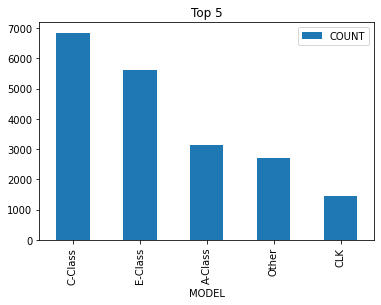

In [30]:
%matplotlib inline
df_col_frequency.plot.bar(x = 'MODEL',
                          y = 'COUNT',
                          title = 'Top ' + str(top_n));

#### Python Seaborn 패키지 설치하기

In [31]:
!pip install seaborn

#### 데이터세트의 학습 및 테스트 데이터 분리하기

In [32]:
col_name_1 = 'PRICE'
col_name_2 = 'YEAR'

from hana_ml.algorithms.pal import partition
df_remote_sample, df_remote_ignore1, df_remote_ignore2 = partition.train_test_val_split(
                               data = df_remote, 
                               random_seed = 1972,
                               training_percentage = 0.01,
                               testing_percentage = 0.99,
                               validation_percentage = 0)
df_sample = df_remote_sample.select(col_name_1, col_name_2).collect()

#### 조인트플롯

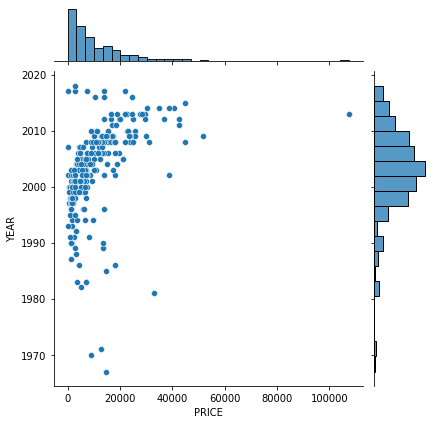

In [33]:
%matplotlib inline
import seaborn as sns
sns.jointplot(x=col_name_1, y=col_name_2, data=df_sample);

#### 데이터세트 선택하기 : YEAR >= 2000 & PRICE < 50000

In [34]:
df_remote = df_remote.filter('YEAR >= 2000')
df_remote = df_remote.filter('PRICE < 50000')
df_remote = df_remote.dropna()
df_remote.count()

18066

#### 상관 분석하기

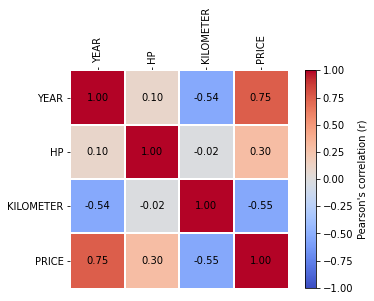

In [35]:
import matplotlib.pyplot as plt
from hana_ml.visualizers.eda import EDAVisualizer
f = plt.figure()
ax1 = f.add_subplot(111) # 111 refers to 1x1 grid, 1st subplot
eda = EDAVisualizer(ax1)
ax, corr_data = eda.correlation_plot(data = df_remote.drop(['CAR_ID']),
                                     cmap = 'coolwarm')

#### PRICE 컬럼 데이터타입 변경하기

In [36]:
df_remote = df_remote.cast('PRICE', 'DOUBLE')

#### HANA View 생성하기

In [37]:
df_remote.save(where = ('XA2664_01', 'USEDCARPRICES_PREPVIEW_TA99'), table_type = 'VIEW', force = True)

#### HANA 세션 종료

In [38]:
conn.close()

#### 

## 3. M/L 모델 학습(Train ML model)

#### HANA DB 세션 연결

In [39]:
from notebook_hana_connector.notebook_hana_connector import NotebookConnectionContext
conn = NotebookConnectionContext(connectionId = 'XA2648_HANA')

#### 학습/테스트 데이터세트(HANA View)를 DataFrame으로 읽어들이기

In [40]:
import hana_ml.dataframe as dataframe
df_remote = conn.table(table = 'USEDCARPRICES_PREPVIEW_TA99', schema = 'XA2664_01')

In [41]:
df_remote.head(n = 5).collect()

,CAR_ID,VEHICLETYPE,YEAR,GEARBOX,HP,MODEL,KILOMETER,FUELTYPE,PRICE
0,0,bus,2004,manual,102,A-Class,150000,petrol,1850.0
1,2,limousine,2004,automatic,122,E-Class,150000,diesel,3500.0
2,4,bus,2012,automatic,109,B-Class,150000,diesel,13500.0
3,5,kombi,2008,manual,156,C-Class,150000,petrol,7999.0
4,6,andere,2003,manual,82,Vito,150000,diesel,1400.0


#### 학습 및 테스트 데이터 분리하기 - 비율 70% : 30%

In [42]:
from hana_ml.algorithms.pal import partition
df_remote_train, df_remote_test, df_remote_ignore = partition.train_test_val_split(random_seed = 1972,
                                                                                   data = df_remote, 
                                                                                   training_percentage = 0.7, 
                                                                                   testing_percentage = 0.3,
                                                                                   validation_percentage = 0)

In [43]:
print('Size of training subset: ' + str(df_remote_train.count()))
print('Size of test subset: ' + str(df_remote_test.count()))

Size of training subset: 12646
Size of test subset: 5420


#### 모델 생성하기

In [44]:
from hana_ml.algorithms.pal import trees
hgb_reg = trees.HybridGradientBoostingRegressor(random_state = 42,
                                                n_estimators = 50,
                                                max_depth = 5,
                                                learning_rate = 0.3,
                                                min_sample_weight_leaf = 1,
                                                min_samples_leaf = 1,
                                                lamb = 1,
                                                alpha = 1)

# Specify the model's predictors
features = ['YEAR', 'HP', 'KILOMETER', 'VEHICLETYPE', 'GEARBOX', 'MODEL', 'FUELTYPE']

# Train the model
hgb_reg.fit(data = df_remote_train, 
            features = features, 
            key = "CAR_ID", 
            label = 'PRICE')

#### 테스트 데이터세트에 대한 추론하기

In [45]:
df_remote_act_pred = df_remote_test.alias('L').join(
    hgb_reg.predict(data = df_remote_test, features = features, key = 'CAR_ID').alias('R'),
    'L.CAR_ID = R.CAR_ID', 
    select=[('L.CAR_ID', 'CAR_ID'), 'MODEL', ('PRICE','ACTUALS'), ('SCORE', 'PREDICTIONS')])
df_remote_act_pred.head(5).collect()

,CAR_ID,MODEL,ACTUALS,PREDICTIONS
0,4,B-Class,13500.0,11702.465048370219
1,5,C-Class,7999.0,10223.283673825445
2,6,Vito,1400.0,3262.1822525254606
3,7,Sprinter,5000.0,6720.255353675897
4,8,E-Class,20300.0,23611.732565428778


#### 모델 평가 메트릭 RMSE 구하기

In [46]:
import numpy as np
df_remote_se = df_remote_act_pred.select('CAR_ID',
                                        'ACTUALS',
                                        'PREDICTIONS',
                                        ('(ACTUALS - PREDICTIONS) * (ACTUALS - PREDICTIONS) ', 'ERRORSQ'))
df_mse = df_remote_se.agg([('avg', 'ERRORSQ', 'MSE')]).collect()
rmse = np.sqrt(float(df_mse.iloc[0:,0]))
print('RMSE: ' + str(round(rmse, 2)))

RMSE: 2833.28


#### 최고 성능 모델을 위한 하이퍼파라미터 구하기

In [47]:
n_estimators = [10, 20, 30, 40, 50]
max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]

In [48]:
import pandas as pd
from math import sqrt
from sapdi import tracking

# Dataframe to store hyperparameters with model quality
df_hyper_quality = pd.DataFrame(columns=['N_ESTIMATORS', 'MAX_DEPTH', 'RMSE'])

# Iterate through all parameter combinations
from hana_ml.algorithms.pal import trees
for aa in n_estimators:
    for bb in max_depth:
        hgb_reg = trees.HybridGradientBoostingRegressor(#conn_context=conn,
                                                random_state = 42,
                                                min_samples_leaf = 1,
                                                n_estimators = aa,
                                                max_depth = bb)

        # Train the regression with the current parameters
        hgb_reg.fit(data = df_remote_train, 
                       features = features, 
                       key = "CAR_ID", 
                       label = 'PRICE')
        
        # Evaluate the model on the test data
        df_remote_act_pred = df_remote_test.alias('L').join(
                                hgb_reg.predict(data = df_remote_test, features = features, key = 'CAR_ID').alias('R'),
                                'L.CAR_ID = R.CAR_ID', 
                                select=[('L.CAR_ID', 'CAR_ID'), ('PRICE','ACTUALS'), ('"SCORE"', 'PREDICTIONS')])
        df_remote_se = df_remote_act_pred.select('CAR_ID',
                                                     'ACTUALS',
                                                     'PREDICTIONS',
                                                     ('(ACTUALS - PREDICTIONS) * (ACTUALS - PREDICTIONS) ', 'ERRORSQ'))
        df_mse = df_remote_se.agg([('avg', 'ERRORSQ', 'MSE')]).collect()
        rmse = np.sqrt(float(df_mse.iloc[0:,0]))
        
        # Print a status update
        print('n_estimators: ', aa, ' | max_depth: ', bb)
        print('RMSE on test data: ' + str(round(rmse, 2)))
        print()
        
        # Add the parameters and the RMSE to the collection in Python
        df_hyper_quality = df_hyper_quality.append({'N_ESTIMATORS': aa,
                                                    'MAX_DEPTH': bb,
                                                    'RMSE': rmse},
                                                    ignore_index = True)
        
        # Add the parameters and RMSE to the ML Scenario
        run = tracking.start_run(run_collection_name="Car price experiments")
        tracking.log_parameters({"n_estimators": aa,
                                 "max_depth": bb})
        tracking.log_metrics({"RMSE": rmse})
        tracking.end_run()        
        
print('Done')

n_estimators:  10  | max_depth:  2
RMSE on test data: 3944.12

n_estimators:  10  | max_depth:  3
RMSE on test data: 3563.14

n_estimators:  10  | max_depth:  4
RMSE on test data: 3272.14

n_estimators:  10  | max_depth:  5
RMSE on test data: 3120.39

n_estimators:  10  | max_depth:  6
RMSE on test data: 2959.72

n_estimators:  10  | max_depth:  7
RMSE on test data: 2897.04

n_estimators:  10  | max_depth:  8
RMSE on test data: 2863.55

n_estimators:  10  | max_depth:  9
RMSE on test data: 2877.63

n_estimators:  10  | max_depth:  10
RMSE on test data: 2882.59

n_estimators:  20  | max_depth:  2
RMSE on test data: 3424.22

n_estimators:  20  | max_depth:  3
RMSE on test data: 3191.77

n_estimators:  20  | max_depth:  4
RMSE on test data: 3042.67

n_estimators:  20  | max_depth:  5
RMSE on test data: 2921.59

n_estimators:  20  | max_depth:  6
RMSE on test data: 2797.49

n_estimators:  20  | max_depth:  7
RMSE on test data: 2762.14

n_estimators:  20  | max_depth:  8
RMSE on test data: 

In [49]:
df_hyper_quality.sort_values(by = 'RMSE', ascending = True).head(5)

,N_ESTIMATORS,MAX_DEPTH,RMSE
40,50.0,6.0,2744.919082
23,30.0,7.0,2752.417993
32,40.0,7.0,2761.070329
14,20.0,7.0,2762.138731
41,50.0,7.0,2767.386140


#### 최적의 하이퍼파라미터로 모델 생성하기 

In [50]:
hgb_reg = trees.HybridGradientBoostingRegressor(random_state = 42,
                                                min_samples_leaf = 1,
                                                n_estimators = 50,
                                                max_depth = 5)
hgb_reg.fit(data = df_remote_train, 
            features = features, 
            key = "CAR_ID", 
            label = 'PRICE')

In [51]:
df_remote_act_pred = df_remote_test.alias('L').join(
    hgb_reg.predict(data = df_remote_test, features = features, key = 'CAR_ID').alias('R'),
    'L.CAR_ID = R.CAR_ID', 
    select=[('L.CAR_ID', 'CAR_ID'), 'MODEL', ('PRICE','ACTUALS'), ('SCORE', 'PREDICTIONS')])
df_remote_act_pred.head(5).collect()

,CAR_ID,MODEL,ACTUALS,PREDICTIONS
0,4,B-Class,13500.0,11702.483725396289
1,5,C-Class,7999.0,10223.282544495501
2,6,Vito,1400.0,3262.178933430203
3,7,Sprinter,5000.0,6720.256257233489
4,8,E-Class,20300.0,23611.73041065052


#### 모델 성능 지표

In [52]:
import numpy as np
df_remote_se = df_remote_act_pred.select('CAR_ID',
                                             'ACTUALS',
                                             'PREDICTIONS',
                                             'MODEL',
                                             ('(ACTUALS - PREDICTIONS) * (ACTUALS - PREDICTIONS) ', 'ERRORSQ'))
df_mse = df_remote_se.agg([('avg', 'ERRORSQ', 'MSE')]).collect()
rmse = np.sqrt(float(df_mse.iloc[0:,0]))
print('RMSE: ' + str(round(rmse, 2)))

RMSE: 2835.61


#### 차량 모델 별 모델 성능 지료

In [53]:
df_mse = df_remote_se.agg([('avg', 'ERRORSQ', 'MSE')], group_by = ['MODEL']).collect()
df_mse['RMSE'] = np.sqrt(df_mse['MSE'])
df_mse.sort_values(by = ['RMSE'], ascending = True)

,MODEL,MSE,RMSE
7,A-Class,2.790386e+06,1670.444906
1,C-Class,4.355905e+06,2087.080532
0,B-Class,4.591800e+06,2142.848487
2,Vito,6.258489e+06,2501.697186
5,SLK,6.279180e+06,2505.829162
9,CLK,8.183236e+06,2860.635535
10,GLK,8.215748e+06,2866.312681
4,E-Class,8.387084e+06,2896.046245
3,Sprinter,1.340327e+07,3661.047571
12,Other,1.356537e+07,3683.118933


#### 모델 저장하기

In [54]:
from hana_ml.model_storage import ModelStorage
MODEL_SCHEMA = 'XA2664_01' # HANA schema in which models are to be saved
model_storage = ModelStorage(connection_context=conn, schema = MODEL_SCHEMA)
hgb_reg.name = 'Car Price Est Model TA99'
model_storage.save_model(model=hgb_reg, if_exists = 'replace')

#### 모델 목록 출력하기

In [55]:
model_storage.list_models()

,NAME,VERSION,LIBRARY,CLASS,JSON,TIMESTAMP,MODEL_STORAGE_VER
0,Bank Marketing Model TA99,1,APL,hana_ml.algorithms.apl.gradient_boosting_class...,"{""model_attributes"": {""name"": ""Bank Marketing ...",2021-05-11 13:28:29,1
1,Car Price Est Model TA99,1,PAL,hana_ml.algorithms.pal.trees.HybridGradientBoo...,"{""model_attributes"": {""n_estimators"": 50, ""ran...",2021-05-12 13:28:46,1


#### HANA DB 세션 종료

In [56]:
conn.close()

#### 

## 4. M/L 모델 추론(Apply ML model)

#### HANA DB 세션 연결

In [57]:
from notebook_hana_connector.notebook_hana_connector import NotebookConnectionContext
conn = NotebookConnectionContext(connectionId = 'XA2648_HANA')

#### 모델 읽기

In [58]:
from hana_ml.model_storage import ModelStorage
MODEL_SCHEMA = 'XA2664_01' # HANA schema in which models are to be saved
model_storage = ModelStorage(connection_context=conn, schema = MODEL_SCHEMA)
model_name = 'Car Price Est Model TA99'
hgb_reg_saved = model_storage.load_model(name=model_name, version=1)

#### 신규 차량 데이터세트

In [59]:
# Create HANA dataframe for the table that holds the data for prediction
df_pushdown_new = conn.table("USEDCARPRICES_TOPREDICT_TA99", schema="XA2664_01")
df_pushdown_new.head(3).collect()

,CAR_ID,VEHICLETYPE,YEAR,GEARBOX,HP,MODEL,KILOMETER,FUELTYPE
0,1,coupe,2006,manual,232,CLK,50000,petrol
1,2,coupe,2006,manual,232,CLK,150000,petrol


#### 신규 차량 데이터세트에 대한 가격 예측

In [60]:
features = ["VEHICLETYPE", "YEAR", "GEARBOX", "HP", "MODEL", "KILOMETER", "FUELTYPE"]
#features = ['YEAR', 'HP', 'KILOMETER', 'VEHICLETYPE', 'GEARBOX', 'MODEL', 'FUELTYPE']
df_predict = hgb_reg_saved.predict(df_pushdown_new, features=features, key="CAR_ID").select("CAR_ID", "SCORE").collect()
df_predict

,CAR_ID,SCORE
0,1,16505.63738796052
1,2,11949.231341638377


#### 신규 차량 데이터의 가격 예측에 대한 플롯

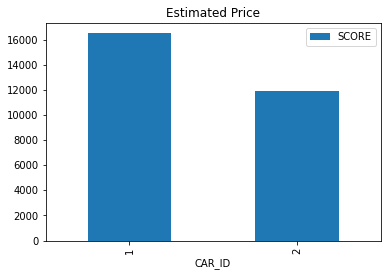

In [61]:
import pandas as pd
df_predict["SCORE"] = pd.to_numeric(df_predict["SCORE"])
df_predict['CAR_ID'] = df_predict['CAR_ID'].astype(str)
df_predict.plot.bar(x="CAR_ID", y="SCORE", title="Estimated Price");

#### 신규 데이터세트에 대한 결과(예측) 테이블 생성하기

In [62]:
hgb_reg_saved.predict(df_pushdown_new, features=features, key="CAR_ID").save(where=("XA2664_01", "USEDCARPRICES_PREDICTED_TA99"), table_type="COLUMN")

#### HANA DB 세션 종료

In [63]:
conn.close()

#### 